Experiment 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
data_source = pd.read_csv('dataset_exp2.csv')
data_source.columns = data_source.columns.str.strip()

In [4]:
data_source.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,0
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,0
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,0
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0


In [5]:
data_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             170366 non-null  int64  
 1   Flow Duration                170366 non-null  int64  
 2   Total Fwd Packets            170366 non-null  int64  
 3   Total Backward Packets       170366 non-null  int64  
 4   Total Length of Fwd Packets  170366 non-null  int64  
 5   Total Length of Bwd Packets  170366 non-null  int64  
 6   Fwd Packet Length Max        170366 non-null  int64  
 7   Fwd Packet Length Min        170366 non-null  int64  
 8   Fwd Packet Length Mean       170366 non-null  float64
 9   Fwd Packet Length Std        170366 non-null  float64
 10  Bwd Packet Length Max        170366 non-null  int64  
 11  Bwd Packet Length Min        170366 non-null  int64  
 12  Bwd Packet Length Mean       170366 non-null  float64
 13 

In [6]:
data_source.shape


(170366, 79)

In [7]:
data_source.isnull().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

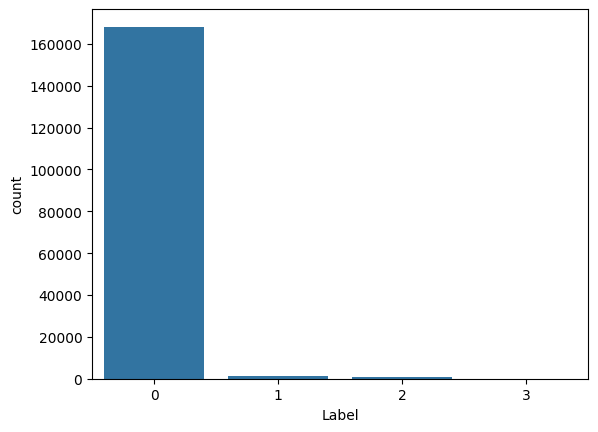

In [8]:
sns.countplot(x=data_source['Label'])

In [9]:
# Keep the important features for web attack
columns_to_keep = [
    'Init_Win_bytes_forward',
    'Subflow Fwd Bytes',
    'Init_Win_bytes_backward',
    'Total Length of Fwd Packets',
    'Label'
]
data_source = data_source[columns_to_keep]
data_source.head()

,Init_Win_bytes_forward,Subflow Fwd Bytes,Init_Win_bytes_backward,Total Length of Fwd Packets,Label
0,571,9668,2079,9668,0
1,390,11364,2081,11364,0
2,-1,0,-1,0,0
3,8192,2330,513,2330,0
4,-1,102,-1,102,0


In [10]:
# Normal (Label=0), Brute Force (Label=1), XSS (Label=2), and SQL Injection (Label=3) samples
normal_samples = data_source[data_source['Label'] == 0]
brute_force_samples = data_source[data_source['Label'] == 1]
xss_samples = data_source[data_source['Label'] == 2]
sql_samples = data_source[data_source['Label'] == 3]


In [11]:
# Print the number of samples in each class
print("Number of samples in each class:")
print("Normal:", len(normal_samples))
print("Brute Force:", len(brute_force_samples))
print("XSS:", len(xss_samples))
print("SQL:", len(sql_samples))

Number of samples in each class:
Normal: 168186
Brute Force: 1507
XSS: 652
SQL: 21


In [12]:
normal_train, normal_test = train_test_split(normal_samples, train_size=3000, test_size=1000)
brute_force_train, brute_force_test = train_test_split(brute_force_samples, train_size=840, test_size=667)
xss_train, xss_test = train_test_split(xss_samples, train_size=350, test_size=302)
sql_train, sql_test = train_test_split(sql_samples, train_size=10, test_size=11)

In [13]:
# Concatenate all sets to get the final training and testing sets
train = pd.concat([normal_train, brute_force_train, xss_train, sql_train])
test = pd.concat([normal_test, brute_force_test, xss_test, sql_test])

In [14]:
train.shape

(4200, 5)

In [15]:
test.shape

(1980, 5)

In [16]:
# Extract features and labels
x_train = train.drop('Label', axis=1)
x_test = test.drop('Label', axis=1)

y_train = train['Label']
y_test = test['Label']

In [17]:
# Scale the features in both the training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

**K-Nearest Neighbor Model**

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=7) 
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7)

In [19]:
# Predictions, Evaluate, and print accuracy for KNN
y_pred_train_knn = knn_model.predict(X_train_scaled)
y_pred_test_knn = knn_model.predict(X_test_scaled)

K-Nearest Neighbor Model:
Training Accuracy: 0.7557142857142857
Test Accuracy: 0.5686868686868687
Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.99      0.70      1000
 Brute Force       0.97      0.17      0.29       667
         XSS       0.82      0.05      0.09       302
         SQL       0.50      0.09      0.15        11

    accuracy                           0.57      1980
   macro avg       0.71      0.33      0.31      1980
weighted avg       0.73      0.57      0.47      1980


Confusion Matrix:
[[995   2   3   0]
 [551 116   0   0]
 [286   1  14   1]
 [  9   1   0   1]]


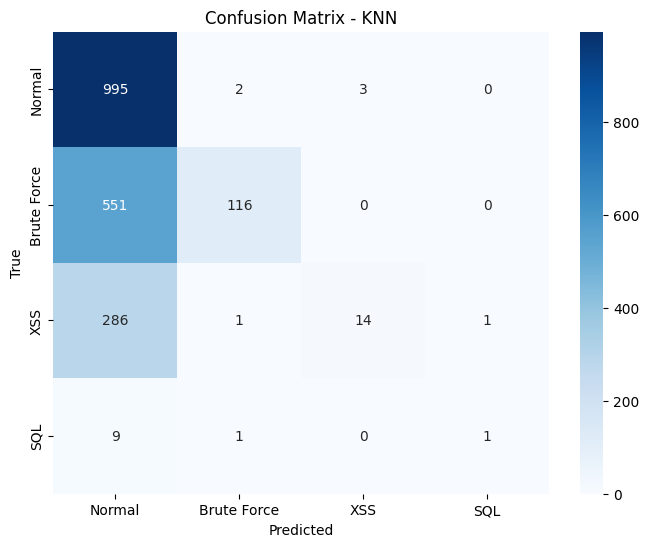

In [20]:
print("K-Nearest Neighbor Model:")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_knn))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_knn))

class_report = classification_report(y_test, y_pred_test_knn, target_names=['Normal', 'Brute Force', 'XSS', 'SQL'])          
print('Classification Report:')
print(class_report)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_knn))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_knn), annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'],
    yticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'])
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Decision Trees Model**

In [21]:
dt_model = DecisionTreeClassifier(max_depth = 2)
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=2)

In [22]:
y_pred_train_dt = dt_model.predict(X_train_scaled)
y_pred_test_dt = dt_model.predict(X_test_scaled)

Decision Trees Model:
Training Accuracy: 0.871904761904762
Test Accuracy: 0.7904040404040404
Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.99      0.94      1000
 Brute Force       0.66      0.87      0.75       667
         XSS       0.00      0.00      0.00       302
         SQL       0.00      0.00      0.00        11

    accuracy                           0.79      1980
   macro avg       0.39      0.46      0.42      1980
weighted avg       0.67      0.79      0.73      1980


Confusion Matrix:
[[987  13   0   0]
 [ 89 578   0   0]
 [ 23 279   0   0]
 [ 11   0   0   0]]


c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

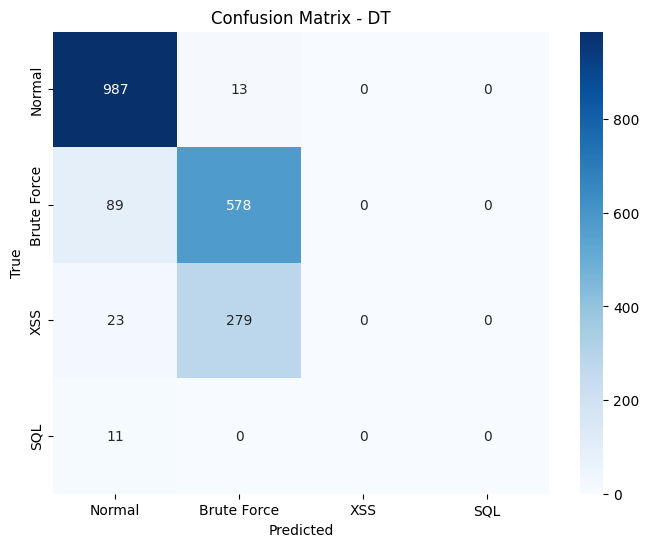

In [23]:
# Print results
print("Decision Trees Model:")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_dt))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_dt))

# Print accuracy for each type of attack
class_report = classification_report(y_test, y_pred_test_dt, target_names=['Normal', 'Brute Force', 'XSS', 'SQL'])          
print('Classification Report:')
print(class_report)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_dt))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_dt), annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'],
    yticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'])
plt.title('Confusion Matrix - DT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Random Forest Model**

In [24]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [25]:
y_pred_train_rf = rf_model.predict(X_train_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)

Random Forest Model:
Training Accuracy: 0.9197619047619048
Test Accuracy: 0.8484848484848485
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1000
 Brute Force       0.70      0.99      0.82       667
         XSS       0.93      0.05      0.09       302
         SQL       0.83      0.91      0.87        11

    accuracy                           0.85      1980
   macro avg       0.86      0.74      0.69      1980
weighted avg       0.88      0.85      0.80      1980


Confusion Matrix:
[[995   4   0   1]
 [  5 661   1   0]
 [  8 279  14   1]
 [  0   1   0  10]]


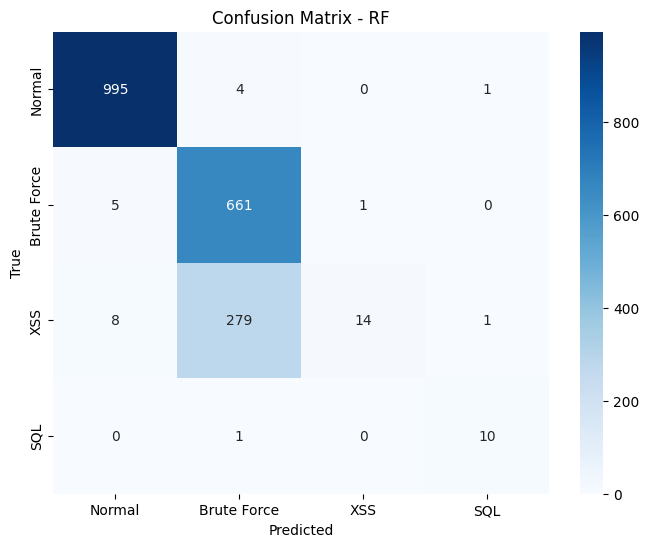

In [26]:
# Print results
print("Random Forest Model:")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_rf))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_rf))

# Print accuracy for each type of attack
class_report = classification_report(y_test, y_pred_test_rf, target_names=['Normal', 'Brute Force', 'XSS', 'SQL'])          # zero_division=1
print('Classification Report:')
print(class_report)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_rf))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_rf), annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'],
    yticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'])
plt.title('Confusion Matrix - RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Support Vector Machine Model**

In [27]:
# SVM Model for Multi-class Classification
svm_model = SVC(kernel = 'linear', C = 1)  # 'ovr' for one-vs-rest strategy
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, kernel='linear')

In [28]:
# Predictions, Evaluate, and print accuracy for SVM
y_pred_train_svm = svm_model.predict(X_train_scaled)
y_pred_test_svm = svm_model.predict(X_test_scaled)

Support Vector Machine Model:
Training Accuracy: 0.8514285714285714
Test Accuracy: 0.7717171717171717
Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92      1000
 Brute Force       0.63      0.85      0.73       667
         XSS       0.00      0.00      0.00       302
         SQL       0.00      0.00      0.00        11

    accuracy                           0.77      1980
   macro avg       0.38      0.45      0.41      1980
weighted avg       0.66      0.77      0.71      1980


Confusion Matrix:
[[960  40   0   0]
 [ 99 568   0   0]
 [ 15 287   0   0]
 [ 11   0   0   0]]


c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

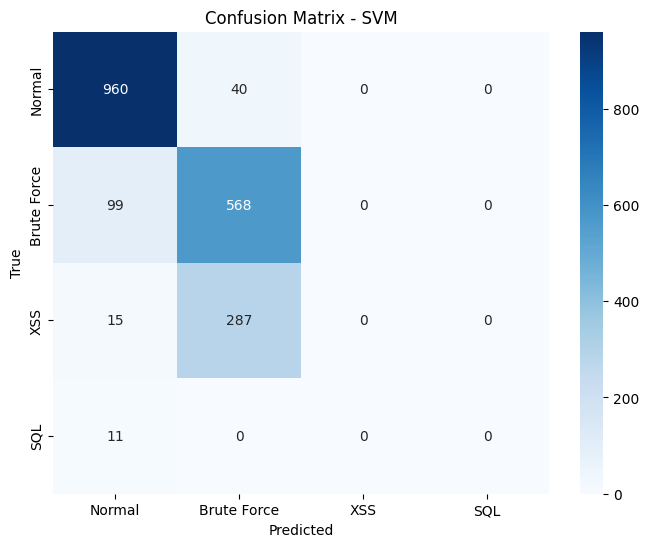

In [29]:
# Print results
print("Support Vector Machine Model:")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_svm))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_svm))

# Print accuracy for each type of attack
class_report = classification_report(y_test, y_pred_test_svm, target_names=['Normal', 'Brute Force', 'XSS', 'SQL'])          # zero_division=1
print('Classification Report:')
print(class_report)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_svm))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_svm), annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'],
    yticklabels=['Normal', 'Brute Force', 'XSS', 'SQL'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cvnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                Model  Accuracy  Precision    Recall  F1-Score
0  K-nearest neighbor  0.568687   0.726990  0.568687  0.467315
1      Decision Trees  0.790404   0.672890  0.790404  0.725861
2      Random Forests  0.848485   0.881153  0.848485  0.795092
3                 SVM  0.771717   0.660654  0.771717  0.710078


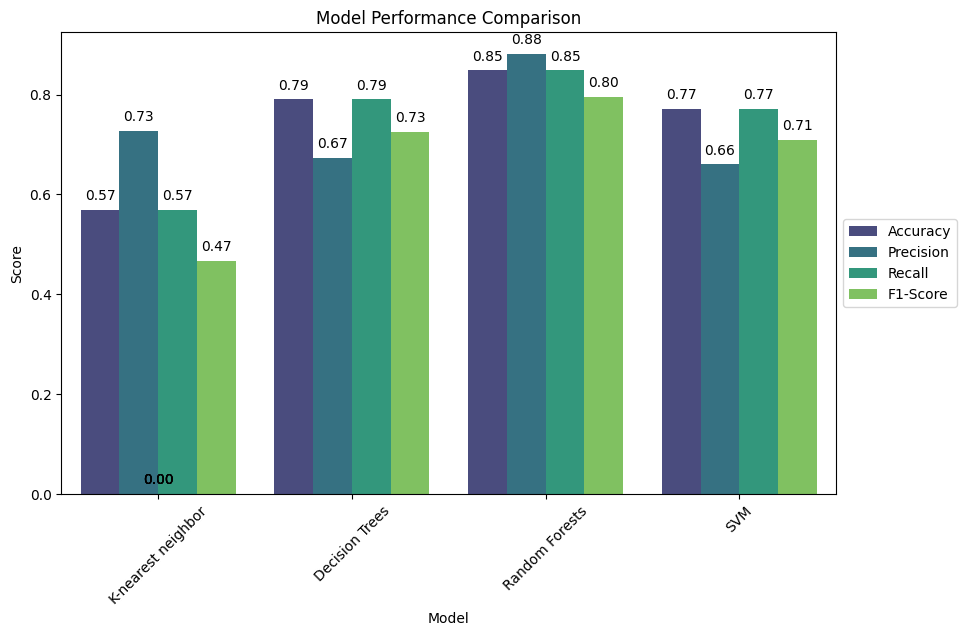

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Your existing code for SVM results printing and confusion matrix heatmap

# Initialize an empty DataFrame

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Define a function to add model results to the DataFrame
def add_result(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Adjusted for multiclass
    recall = recall_score(y_true, y_pred, average='weighted')  # Adjusted for multiclass
    f1 = f1_score(y_true, y_pred, average='weighted')  # Adjusted for multiclass

    results_df.loc[len(results_df)] = [model_name, accuracy, precision, recall, f1]

# K-nearest neighbor
add_result("K-nearest neighbor", y_test, y_pred_test_knn)

# Decision Trees
add_result("Decision Trees", y_test, y_pred_test_dt)

# Random Forests
add_result("Random Forests", y_test, y_pred_test_rf)

# SVM
add_result("SVM", y_test, y_pred_test_svm)


# Print the results table
print(results_df)


# Plot the results
plt.figure(figsize=(10, 6))
metrics_df = pd.melt(results_df, id_vars='Model', var_name='Metric', value_name='Score')
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette='viridis')

# Add values on top of each column
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend outside the plot

# Show the plot
plt.show()



**Comparison Between The Models**

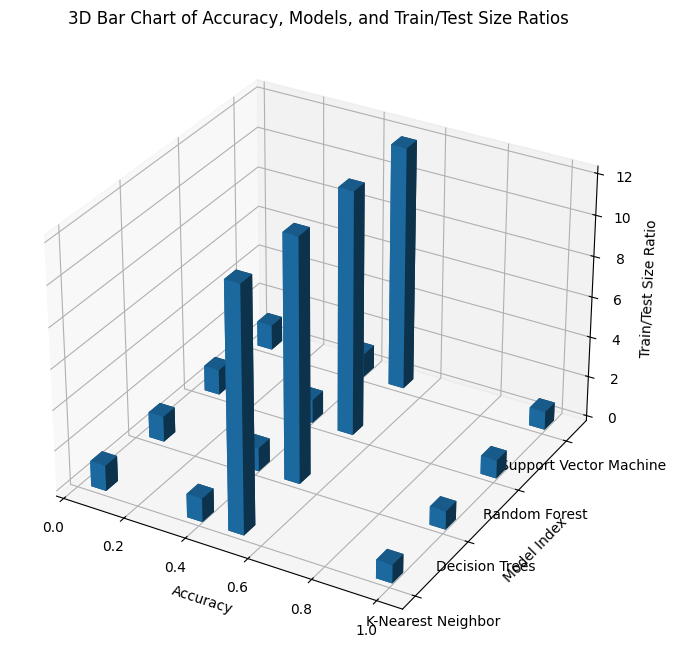

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you already have these variables from your train-test splits
train_sizes = [12000, 840, 350, 10]
test_sizes = [1000, 667, 302, 11]

# Assuming you already have these variables with accuracy values (replace with actual values)
accuracy_values = np.random.rand(len(train_sizes))

models = ['K-Nearest Neighbor', 'Decision Trees', 'Random Forest', 'Support Vector Machine']

# Create a meshgrid for 3D plotting
X, Y = np.meshgrid(accuracy_values, np.arange(len(models)))

# Create a new array for combined train size and test size
size_ratios = np.array(train_sizes) / np.array(test_sizes)

# Initialize a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Repeat the accuracy values for each model
accuracy_values_all = np.repeat(accuracy_values, len(models))

# Repeat the size ratios for each model
size_ratios_all = np.tile(size_ratios, len(models))

# Plot the 3D bar chart
ax.bar3d(X.flatten(), Y.flatten(), np.zeros_like(X).flatten(), 0.05, 0.2, size_ratios_all.flatten(), shade=True)

# Set labels and title
ax.set_xlabel('Accuracy')
ax.set_ylabel('Model Index')
ax.set_zlabel('Train/Test Size Ratio')
ax.set_title('3D Bar Chart of Accuracy, Models, and Train/Test Size Ratios')

# Set ticks and labels
ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)
ax.set_zlim(0, max(size_ratios) + 0.1)

# Show the plot
plt.show()
